In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import random

In [2]:
# Load the datasets
nodes_df = pd.read_csv('nodes.csv')
fleet_df = pd.read_csv('fleet.csv')
distance_matrix = np.loadtxt('distance_matrix.csv', delimiter=',')

In [3]:
# Inspect the nodes
print("Nodes DataFrame:")
print(nodes_df.head())

Nodes DataFrame:
   node_id  x_coordinate  y_coordinate  demand
0        0            30            40       0
1        1            37            52       7
2        2            49            49      30
3        3            52            64      16
4        4            31            62       9


In [4]:
# Inspect the distance_matrix
print("\ndistance_matrix:")
print(distance_matrix)


distance_matrix:
[[ 0.   13.04 19.24 32.14 11.18 22.2  12.37 22.2  30.81 33.24 20.12 25.71
  23.02 30.   33.24 25.71 11.18 20.22 16.16 23.32 10.05]
 [13.04  0.   12.04 20.22 10.   21.93  7.07 15.81 23.85 29.   13.93 20.81
  18.87 25.71 32.14 20.81 10.   21.19 19.24 28.16 16.28]
 [19.24 12.04  0.   15.   20.12 16.76  9.22  9.85 15.   21.21 15.52 24.19
  20.   13.45 25.   24.19 20.12 21.93 23.02 30.81 25.  ]
 [32.14 20.22 15.    0.   30.81 31.26 21.4  21.1  10.   25.71 16.76 33.24
  24.76 16.76 35.   33.24 30.81 33.6  34.18 41.11 38.08]
 [11.18 10.   20.12 30.81  0.   31.26 15.13 25.   33.24 36.01 16.76 15.62
  23.02 32.14 40.31 15.62  0.   31.05 29.41 37.7  25.5 ]
 [22.2  21.93 16.76 31.26 31.26  0.   15.03  5.   20.81 12.17 25.71 41.11
  31.4  16.16 15.   41.11 31.26 25.32 26.4  33.24 30.81]
 [12.37  7.07  9.22 21.4  15.13 15.03  0.   10.2  18.03 22.47 11.66 20.52
  18.03 16.76 26.93 20.52 15.13 20.81 20.62 28.84 22.2 ]
 [22.2  15.81  9.85 21.1  25.    5.   10.2   0.   16.16 11.66 16.

In [5]:
# Inspect the fleet
print("\nFleet DataFrame:")
print(fleet_df)


Fleet DataFrame:
   vehicle_id  capacity
0           0        40
1           1        40
2           2        40
3           3        40
4           4        40


In [6]:
# Inspect the shape of the distance matrix
print(f"\nDistance Matrix Shape: {distance_matrix.shape}")
print(f"Sample value, distance from node 0 to node 1: {distance_matrix[0, 1]:.2f}")


Distance Matrix Shape: (21, 21)
Sample value, distance from node 0 to node 1: 13.04


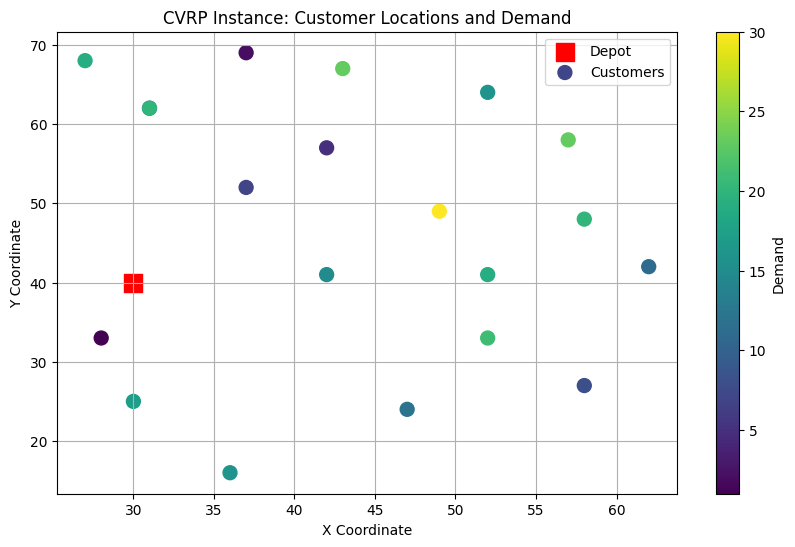

In [7]:
# Visualize the problem
plt.figure(figsize=(10, 6))
# Plot depot
plt.scatter(nodes_df.x_coordinate[0], nodes_df.y_coordinate[0], c='red', s=150, marker='s', label='Depot')
# Plot customers
plt.scatter(nodes_df.x_coordinate[1:], nodes_df.y_coordinate[1:], c=nodes_df.demand[1:], s=100, cmap='viridis', label='Customers')
plt.colorbar(label='Demand')
plt.title('CVRP Instance: Customer Locations and Demand')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

# GA model

In [39]:
vehicle_capacity = fleet_df['capacity'].iloc[0] # Get the first vehicle's capacity (homogeneous fleet)

In [40]:
# --- GA Parameters ---
pop_size = 100
cx_rate = 0.9
mut_rate = 0.05
n_gen = 100
tournament_size = 5

# Extract list of customer IDs (all nodes except depot 0)
customers = nodes_df['node_id'].tolist()
customers.remove(0)
num_customers = len(customers)

# --- Helper Functions ---
def decode_chromosome(chromosome, capacity, demand_list):
    """Decodes a chromosome (permutation of customers) into a list of routes."""
    routes = []
    current_route = [0]  # Start at depot
    current_load = 0
    # demand_list is a list where index = node_id, value = demand
    # We'll create it from nodes_df for easier access: demands[i]
    demands = demand_list

    for customer in chromosome:
        cust_demand = demands[customer]
        if current_load + cust_demand <= capacity:
            current_route.append(customer)
            current_load += cust_demand
        else:
            # Close the current route and start a new one
            current_route.append(0) # Return to depot
            routes.append(current_route)
            current_route = [0, customer] # Start new route from depot
            current_load = cust_demand
    # Add the last route after loop ends
    if current_route:
        current_route.append(0)
        routes.append(current_route)
    return routes

def calculate_total_distance(routes, dist_matrix):
    """Calculates the total distance of a set of routes."""
    total_dist = 0
    for route in routes:
        for i in range(len(route) - 1):
            from_node = route[i]
            to_node = route[i + 1]
            total_dist += dist_matrix[from_node, to_node]
    return total_dist

def calculate_fitness(chromosome, capacity, demands, dist_matrix):
    """Calculates the fitness of a chromosome (1 / total distance)."""
    routes = decode_chromosome(chromosome, capacity, demands)
    total_dist = calculate_total_distance(routes, dist_matrix)
    # Avoid division by zero (though unlikely)
    return 1 / (total_dist + 1e-10)

def tournament_selection(population, fitnesses, k=5):
    """Selects an individual using tournament selection."""
    selected_indices = random.sample(range(len(population)), k)
    best_index = max(selected_indices, key=lambda i: fitnesses[i])
    return population[best_index]

def ordered_crossover(parent1, parent2):
    """Performs Order Crossover (OX1) on two parents."""
    size = len(parent1)
    child = [None] * size

    # Choose two random cut points
    start, end = sorted(random.sample(range(size), 2))
    # Copy segment from parent1 to child
    child[start:end+1] = parent1[start:end+1]

    # Fill remaining positions with genes from parent2 in order
    pointer = (end + 1) % size
    for gene in parent2:
        if gene not in child:
            child[pointer] = gene
            pointer = (pointer + 1) % size
    return child

def swap_mutation(chromosome):
    """Performs swap mutation on a chromosome."""
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

# --- Create demand list for easy access: demands[node_id] = demand ---
demands = nodes_df.set_index('node_id')['demand'].to_dict()

In [41]:
# --- Initialize Population ---
population = []
for _ in range(pop_size):
    chromosome = customers.copy()
    random.shuffle(chromosome)
    population.append(chromosome)

# --- Data structures to track progress ---
best_fitness_history = []
avg_fitness_history = []
best_solution = None
best_distance = float('inf')

In [42]:
# --- Main GA Loop ---
for generation in range(n_gen):
    # Calculate fitness for all individuals
    fitnesses = []
    distances = []
    for chromo in population:
        dist = calculate_total_distance(decode_chromosome(chromo, vehicle_capacity, demands), distance_matrix)
        fit = 1 / (dist + 1e-10)
        fitnesses.append(fit)
        distances.append(dist)
        # Track global best
        if dist < best_distance:
            best_distance = dist
            best_solution = chromo.copy()

    # Record statistics for this generation
    best_fitness_history.append(max(fitnesses))
    avg_fitness_history.append(sum(fitnesses) / len(fitnesses))

    # Create new generation
    new_population = []
    # Elitism: Keep the best individual from the previous generation
    best_index = np.argmax(fitnesses)
    new_population.append(population[best_index])

    # Build the rest of the new population
    while len(new_population) < pop_size:
        # Selection
        parent1 = tournament_selection(population, fitnesses, tournament_size)
        parent2 = tournament_selection(population, fitnesses, tournament_size)

        # Crossover
        if random.random() < cx_rate:
            child1 = ordered_crossover(parent1, parent2)
            child2 = ordered_crossover(parent2, parent1)
        else:
            child1, child2 = parent1.copy(), parent2.copy()

        # Mutation
        if random.random() < mut_rate:
            child1 = swap_mutation(child1)
        if random.random() < mut_rate:
            child2 = swap_mutation(child2)

        new_population.extend([child1, child2])

    # If we have an odd number (due to elitism), trim the last one
    population = new_population[:pop_size]
    # Optional: Print progress every 50 generations
    if generation % 50 == 0:
        print(f"Gen {generation}: Best Dist = {best_distance:.2f}")

Gen 0: Best Dist = 615.91
Gen 50: Best Dist = 475.11


In [43]:
# --- After GA loop ---
print("\nGA Completed.")
print(f"Best Solution Found - Total Distance: {best_distance:.2f}")

# Decode and print the best solution
best_routes = decode_chromosome(best_solution, vehicle_capacity, demands)
print("\nBest Routes:")
for i, route in enumerate(best_routes):
    route_str = " -> ".join(str(node) for node in route)
    route_demand = sum(demands[node] for node in route if node != 0)
    print(f"Route {i+1}: {route_str} | Total Demand: {route_demand} (Cap: {vehicle_capacity})")


GA Completed.
Best Solution Found - Total Distance: 475.11

Best Routes:
Route 1: 0 -> 20 -> 19 -> 18 -> 0 | Total Demand: 34 (Cap: 40)
Route 2: 0 -> 8 -> 3 -> 0 | Total Demand: 39 (Cap: 40)
Route 3: 0 -> 2 -> 1 -> 0 | Total Demand: 37 (Cap: 40)
Route 4: 0 -> 14 -> 9 -> 13 -> 0 | Total Demand: 39 (Cap: 40)
Route 5: 0 -> 16 -> 4 -> 0 | Total Demand: 29 (Cap: 40)
Route 6: 0 -> 7 -> 5 -> 0 | Total Demand: 40 (Cap: 40)
Route 7: 0 -> 6 -> 11 -> 15 -> 0 | Total Demand: 36 (Cap: 40)
Route 8: 0 -> 17 -> 10 -> 12 -> 0 | Total Demand: 40 (Cap: 40)


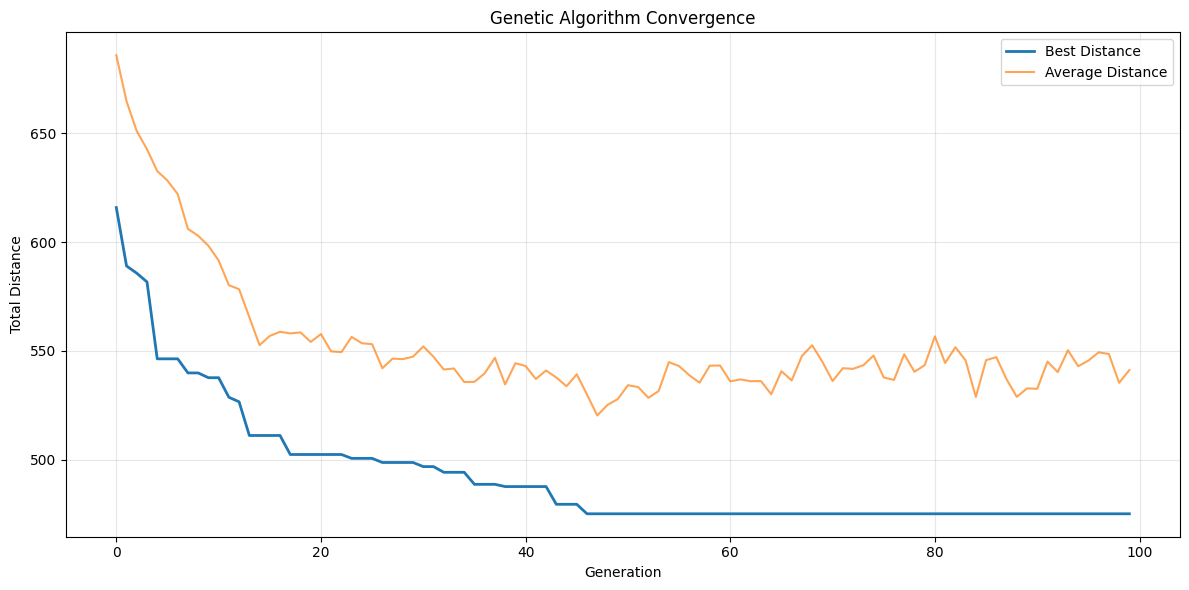

In [44]:
# --- Track GA Convergence and Visualize ---
best_distance_history = [1 / fit for fit in best_fitness_history]
avg_distance_history = [1 / fit for fit in avg_fitness_history]

plt.figure(figsize=(12, 6))
plt.plot(best_distance_history, label='Best Distance', linewidth=2)
plt.plot(avg_distance_history, label='Average Distance', alpha=0.7)
plt.title('Genetic Algorithm Convergence')
plt.xlabel('Generation')
plt.ylabel('Total Distance')
plt.legend()
plt.grid(True, alpha=0.3)
# Format y-axis to not use scientific notation
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.tight_layout()
plt.show()

### Evaluate Constraint Satisfaction

In [45]:
# --- Evaluate Constraint Satisfaction ---
print("\n--- Constraint Satisfaction Evaluation ---")
total_demand_all_routes = 0
all_customers_served = []

for i, route in enumerate(best_routes):
    route_demand = sum(demands[node] for node in route if node != 0)
    total_demand_all_routes += route_demand
    # Check capacity constraint for each route
    if route_demand <= vehicle_capacity:
        print(f"✓ Route {i+1} satisfies capacity constraint: {route_demand} <= {vehicle_capacity}")
    else:
        print(f"✗ Route {i+1} VIOLATES capacity constraint: {route_demand} > {vehicle_capacity}")
    # Collect customers served in this route (excluding depots, 0)
    customers_in_route = [node for node in route if node != 0]
    all_customers_served.extend(customers_in_route)


--- Constraint Satisfaction Evaluation ---
✓ Route 1 satisfies capacity constraint: 34 <= 40
✓ Route 2 satisfies capacity constraint: 39 <= 40
✓ Route 3 satisfies capacity constraint: 37 <= 40
✓ Route 4 satisfies capacity constraint: 39 <= 40
✓ Route 5 satisfies capacity constraint: 29 <= 40
✓ Route 6 satisfies capacity constraint: 40 <= 40
✓ Route 7 satisfies capacity constraint: 36 <= 40
✓ Route 8 satisfies capacity constraint: 40 <= 40


In [46]:
# Check if all customers are served exactly once
all_customers_served_sorted = sorted(all_customers_served)
if all_customers_served_sorted == customers:
    print("✓ All customers are served exactly once.")
else:
    missing = set(customers) - set(all_customers_served)
    duplicates = set([x for x in all_customers_served if all_customers_served.count(x) > 1])
    print(f"✗ Error in customer service. Missing: {missing}. Duplicates: {duplicates}")

# Sanity check: Total demand served vs. known total
known_total_demand = sum(demands.values()) - demands[0] # Subtract depot demand (0)
print(f"Total demand calculated from routes: {total_demand_all_routes}")
print(f"Known total customer demand: {known_total_demand}")
if total_demand_all_routes == known_total_demand:
    print("✓ Total demand matches.")
else:
    print("✗ Total demand does not match!")

✓ All customers are served exactly once.
Total demand calculated from routes: 294
Known total customer demand: 294
✓ Total demand matches.


### GA - Hyperparameter Tuning

In [30]:
# Hyperparameter grid to search
param_grid = {
    'pop_size': [50, 100, 150, 200],
    'cx_rate': [0.6, 0.7, 0.8, 0.9],
    'mut_rate': [0.05, 0.1, 0.15, 0.2],
    'tournament_size': [2, 3, 4, 5]
}

# Fixed parameters
n_gen = 100  # Reduced for faster tuning
n_runs = 3   # Number of runs per combination for reliability

In [31]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def run_ga_with_params(pop_size, cx_rate, mut_rate, tournament_size, n_gen, n_runs=3):
    """
    Runs the GA multiple times with given parameters and returns statistics.
    """
    best_distances = []
    convergence_data = []
    
    for run in range(n_runs):
        # Re-initialize population for each run
        population = []
        for _ in range(pop_size):
            chromosome = customers.copy()
            random.shuffle(chromosome)
            population.append(chromosome)
        
        run_best_distance = float('inf')
        run_convergence = []
        
        # Main GA loop for this run
        for generation in range(n_gen):
            # Calculate fitness for all individuals
            fitnesses = []
            distances = []
            for chromo in population:
                routes = decode_chromosome(chromo, vehicle_capacity, demands)
                dist = calculate_total_distance(routes, distance_matrix)
                fit = 1 / (dist + 1e-10)
                fitnesses.append(fit)
                distances.append(dist)
                if dist < run_best_distance:
                    run_best_distance = dist
            
            run_convergence.append(run_best_distance)
            
            # Create new generation (same logic as before)
            new_population = []
            best_index = np.argmax(fitnesses)
            new_population.append(population[best_index])
            
            while len(new_population) < pop_size:
                parent1 = tournament_selection(population, fitnesses, tournament_size)
                parent2 = tournament_selection(population, fitnesses, tournament_size)
                
                if random.random() < cx_rate:
                    child1 = ordered_crossover(parent1, parent2)
                    child2 = ordered_crossover(parent2, parent1)
                else:
                    child1, child2 = parent1.copy(), parent2.copy()
                
                if random.random() < mut_rate:
                    child1 = swap_mutation(child1)
                if random.random() < mut_rate:
                    child2 = swap_mutation(child2)
                
                new_population.extend([child1, child2])
            
            population = new_population[:pop_size]
        
        best_distances.append(run_best_distance)
        convergence_data.append(run_convergence)
    
    # Calculate statistics
    mean_best = np.mean(best_distances)
    std_best = np.std(best_distances)
    min_best = np.min(best_distances)
    max_best = np.max(best_distances)
    
    return {
        'mean_best_distance': mean_best,
        'std_best_distance': std_best,
        'min_best_distance': min_best,
        'max_best_distance': max_best,
        'all_best_distances': best_distances,
        'convergence_data': convergence_data
    }

# Generate all parameter combinations
param_combinations = list(itertools.product(
    param_grid['pop_size'],
    param_grid['cx_rate'], 
    param_grid['mut_rate'],
    param_grid['tournament_size']
))

print(f"Total combinations to test: {len(param_combinations)}")
print("This will take a while...\n")

# Store results
results = []

# Run tuning with progress bar
for i, (pop_size, cx_rate, mut_rate, tournament_size) in enumerate(tqdm(param_combinations)):
    result = run_ga_with_params(
        pop_size=pop_size,
        cx_rate=cx_rate,
        mut_rate=mut_rate, 
        tournament_size=tournament_size,
        n_gen=n_gen,
        n_runs=n_runs
    )
    
    results.append({
        'pop_size': pop_size,
        'cx_rate': cx_rate,
        'mut_rate': mut_rate,
        'tournament_size': tournament_size,
        'mean_best_distance': result['mean_best_distance'],
        'std_best_distance': result['std_best_distance'],
        'min_best_distance': result['min_best_distance'],
        'max_best_distance': result['max_best_distance'],
        'all_best_distances': result['all_best_distances'],
        'convergence_data': result['convergence_data']
    })

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Find the best parameter combination (lowest mean distance)
best_idx = results_df['mean_best_distance'].idxmin()
best_params = results_df.loc[best_idx]

print("\n" + "="*60)
print("HYPERPARAMETER TUNING RESULTS")
print("="*60)
print(f"Best parameters found:")
print(f"  Population Size: {best_params['pop_size']}")
print(f"  Crossover Rate: {best_params['cx_rate']}")
print(f"  Mutation Rate: {best_params['mut_rate']}")
print(f"  Tournament Size: {best_params['tournament_size']}")
print(f"  Mean Best Distance: {best_params['mean_best_distance']:.2f}")
print(f"  Standard Deviation: {best_params['std_best_distance']:.2f}")

Total combinations to test: 256
This will take a while...



100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [12:07<00:00,  2.84s/it]


HYPERPARAMETER TUNING RESULTS
Best parameters found:
  Population Size: 100
  Crossover Rate: 0.9
  Mutation Rate: 0.05
  Tournament Size: 5
  Mean Best Distance: 475.11
  Standard Deviation: 0.00


### GA - Summary Statistics


--- Summary Statistics by Parameter ---

By Population Size:
                mean       std         min         max
pop_size                                              
50        492.220417  8.469632  478.523333  511.353333
100       486.785365  8.061264  475.110000  506.956667
150       484.277135  7.850790  475.110000  506.886667
200       484.047812  8.147175  475.110000  505.803333

By Crossover Rate:
               mean        std     min         max
cx_rate                                           
0.6      487.260990   6.635226  475.11  508.183333
0.7      486.627396   7.527121  475.11  503.750000
0.8      486.698802   9.726455  475.11  511.213333
0.9      486.743542  10.639109  475.11  511.353333

By Mutation Rate:
                mean       std     min         max
mut_rate                                          
0.05      487.671667  8.680461  475.11  511.213333
0.10      485.524740  8.474111  475.11  508.183333
0.15      486.667344  8.677314  475.11  505.606667
0.20    

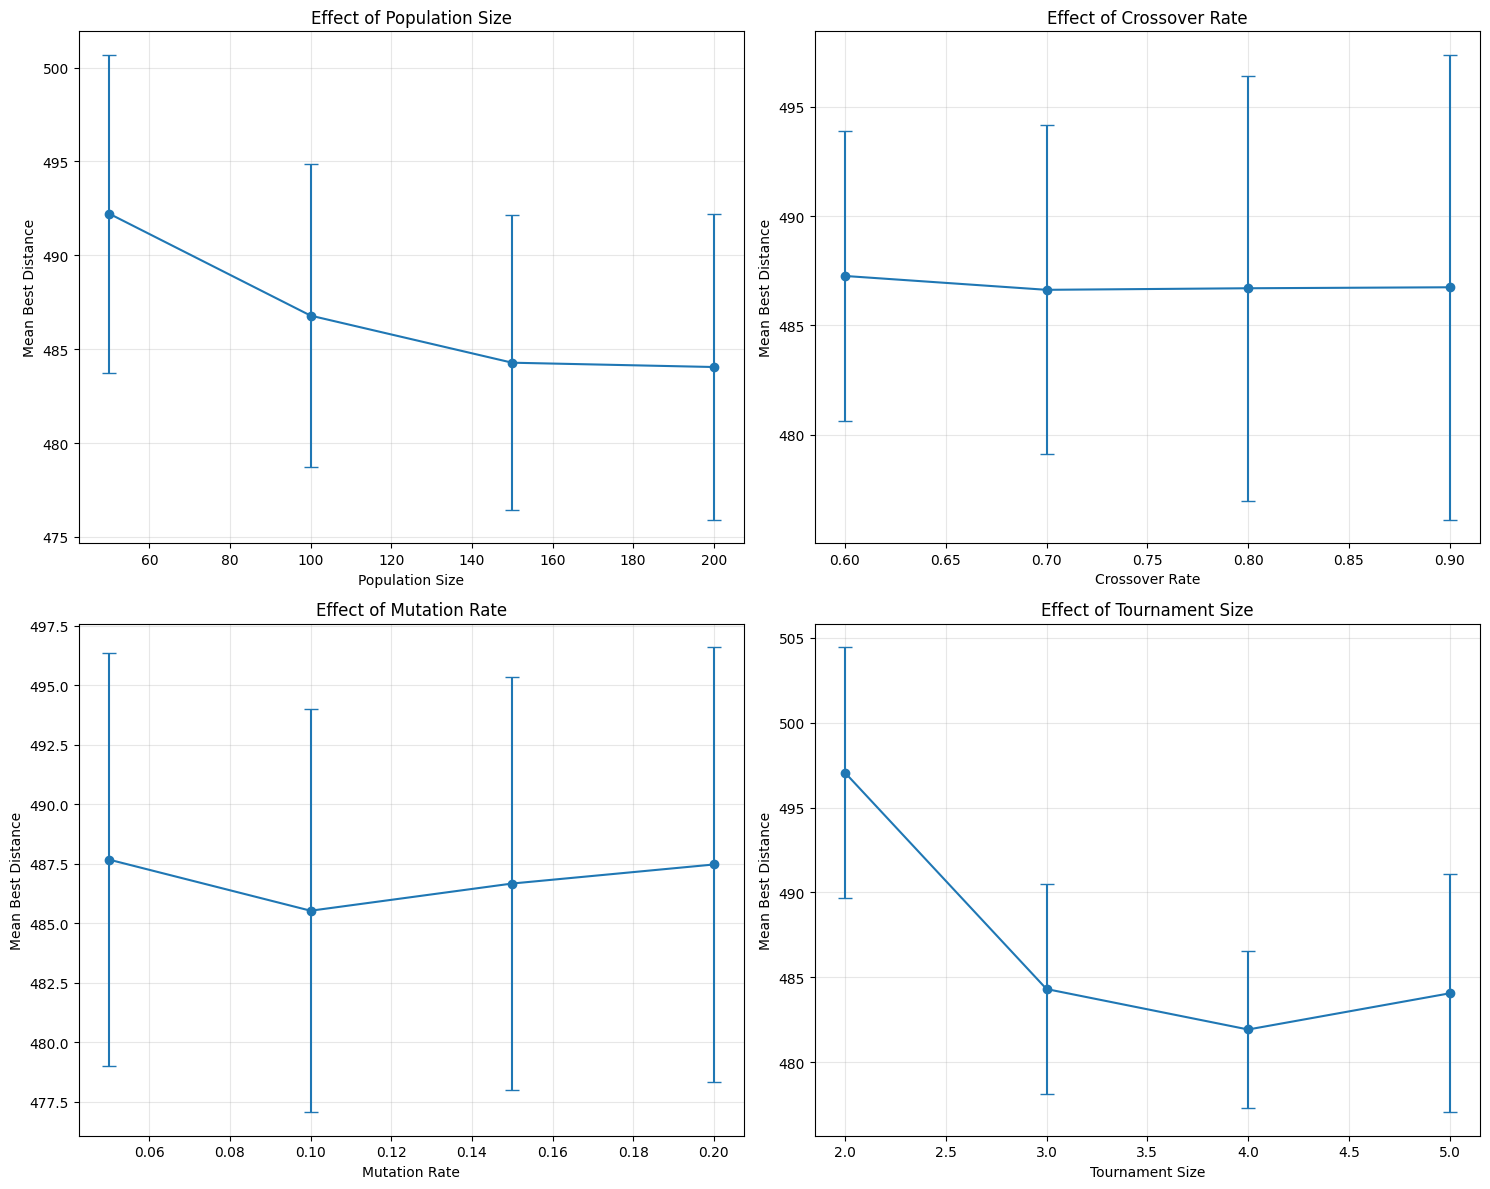

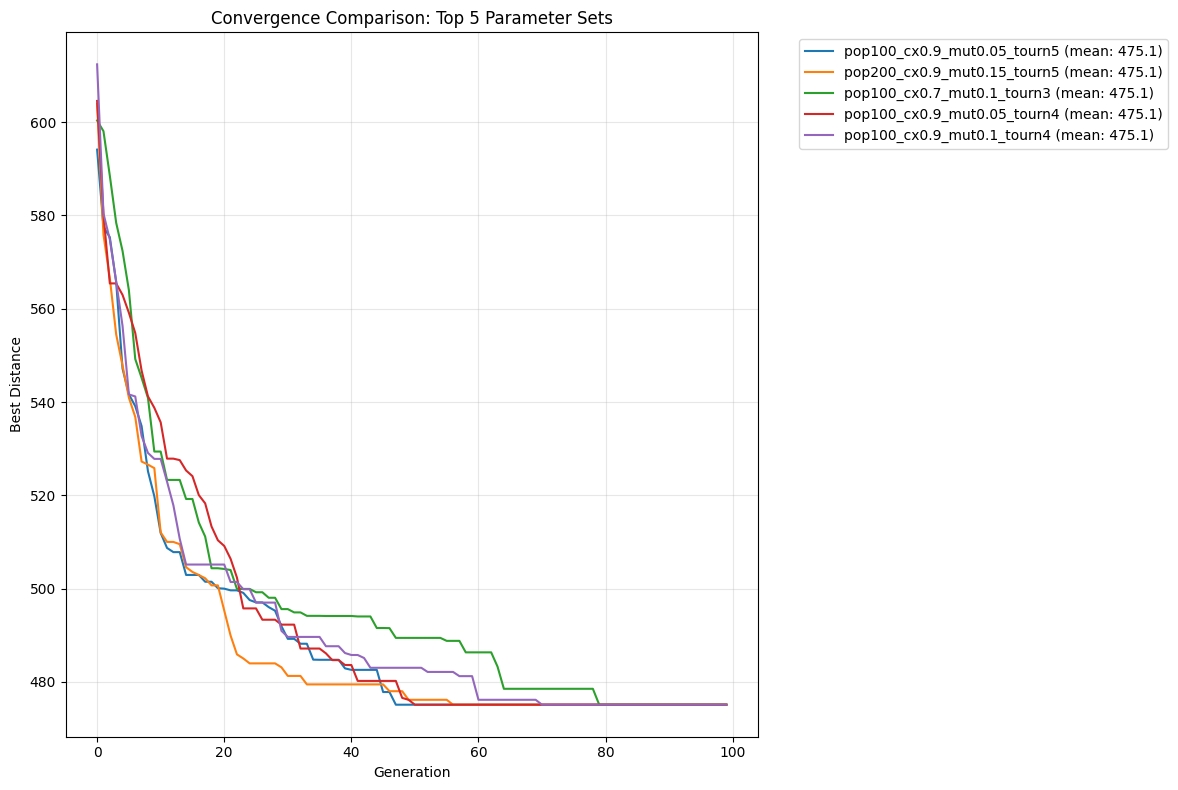

C:\Users\srjtr\AppData\Local\Temp\ipykernel_19700\539982537.py:96: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


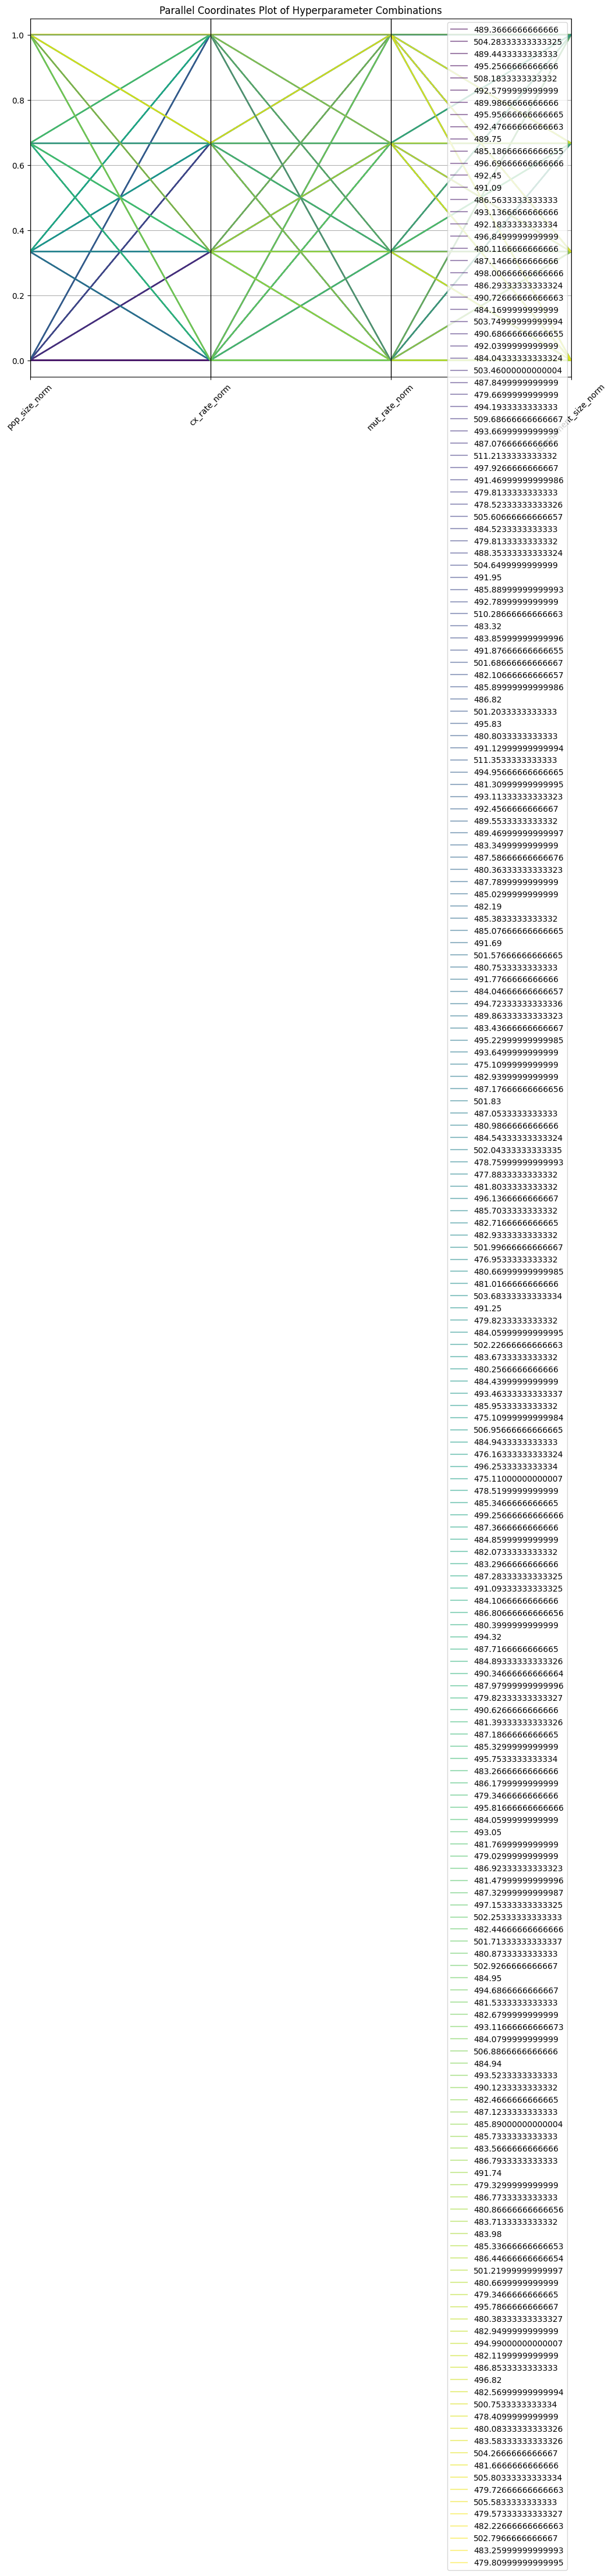

In [47]:
# 1. Summary statistics by parameter
print("\n--- Summary Statistics by Parameter ---")

# Population Size
print("\nBy Population Size:")
pop_summary = results_df.groupby('pop_size')['mean_best_distance'].agg(['mean', 'std', 'min', 'max'])
print(pop_summary)

# Crossover Rate
print("\nBy Crossover Rate:")
cx_summary = results_df.groupby('cx_rate')['mean_best_distance'].agg(['mean', 'std', 'min', 'max'])
print(cx_summary)

# Mutation Rate
print("\nBy Mutation Rate:")
mut_summary = results_df.groupby('mut_rate')['mean_best_distance'].agg(['mean', 'std', 'min', 'max'])
print(mut_summary)

# Tournament Size
print("\nBy Tournament Size:")
tourn_summary = results_df.groupby('tournament_size')['mean_best_distance'].agg(['mean', 'std', 'min', 'max'])
print(tourn_summary)

# 2. Visualization of Results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Population Size vs Mean Best Distance
axes[0,0].errorbar(pop_summary.index, pop_summary['mean'], 
                   yerr=pop_summary['std'], fmt='o-', capsize=5)
axes[0,0].set_xlabel('Population Size')
axes[0,0].set_ylabel('Mean Best Distance')
axes[0,0].set_title('Effect of Population Size')
axes[0,0].grid(True, alpha=0.3)

# Crossover Rate vs Mean Best Distance
axes[0,1].errorbar(cx_summary.index, cx_summary['mean'], 
                   yerr=cx_summary['std'], fmt='o-', capsize=5)
axes[0,1].set_xlabel('Crossover Rate')
axes[0,1].set_ylabel('Mean Best Distance')
axes[0,1].set_title('Effect of Crossover Rate')
axes[0,1].grid(True, alpha=0.3)

# Mutation Rate vs Mean Best Distance
axes[1,0].errorbar(mut_summary.index, mut_summary['mean'], 
                   yerr=mut_summary['std'], fmt='o-', capsize=5)
axes[1,0].set_xlabel('Mutation Rate')
axes[1,0].set_ylabel('Mean Best Distance')
axes[1,0].set_title('Effect of Mutation Rate')
axes[1,0].grid(True, alpha=0.3)

# Tournament Size vs Mean Best Distance
axes[1,1].errorbar(tourn_summary.index, tourn_summary['mean'], 
                   yerr=tourn_summary['std'], fmt='o-', capsize=5)
axes[1,1].set_xlabel('Tournament Size')
axes[1,1].set_ylabel('Mean Best Distance')
axes[1,1].set_title('Effect of Tournament Size')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Convergence comparison for top 5 parameter sets
top_5_indices = results_df.nsmallest(5, 'mean_best_distance').index

plt.figure(figsize=(12, 8))
for idx in top_5_indices:
    row = results_df.loc[idx]
    # Plot mean convergence across runs
    mean_convergence = np.mean(row['convergence_data'], axis=0)
    label = f"pop{row['pop_size']}_cx{row['cx_rate']}_mut{row['mut_rate']}_tourn{row['tournament_size']}"
    plt.plot(mean_convergence, label=f"{label} (mean: {row['mean_best_distance']:.1f})")

plt.xlabel('Generation')
plt.ylabel('Best Distance')
plt.title('Convergence Comparison: Top 5 Parameter Sets')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Parallel coordinates plot for all results
from pandas.plotting import parallel_coordinates

# Normalize the results for parallel coordinates
plot_df = results_df[['pop_size', 'cx_rate', 'mut_rate', 'tournament_size', 'mean_best_distance']].copy()
plot_df['pop_size_norm'] = (plot_df['pop_size'] - plot_df['pop_size'].min()) / (plot_df['pop_size'].max() - plot_df['pop_size'].min())
plot_df['cx_rate_norm'] = (plot_df['cx_rate'] - plot_df['cx_rate'].min()) / (plot_df['cx_rate'].max() - plot_df['cx_rate'].min())
plot_df['mut_rate_norm'] = (plot_df['mut_rate'] - plot_df['mut_rate'].min()) / (plot_df['mut_rate'].max() - plot_df['mut_rate'].min())
plot_df['tournament_size_norm'] = (plot_df['tournament_size'] - plot_df['tournament_size'].min()) / (plot_df['tournament_size'].max() - plot_df['tournament_size'].min())

plt.figure(figsize=(12, 8))
parallel_coordinates(plot_df[['pop_size_norm', 'cx_rate_norm', 'mut_rate_norm', 'tournament_size_norm', 'mean_best_distance']], 
                    'mean_best_distance', colormap='viridis', alpha=0.5)
plt.title('Parallel Coordinates Plot of Hyperparameter Combinations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
# Run final validation with best parameters
print("\n" + "="*60)
print("FINAL VALIDATION WITH BEST PARAMETERS")
print("="*60)

# Use the best parameters for a longer run
final_best_params = {
    'pop_size': int(best_params['pop_size']),
    'cx_rate': best_params['cx_rate'],
    'mut_rate': best_params['mut_rate'],
    'tournament_size': int(best_params['tournament_size']),
    'n_gen': 200,  # Back to original number of generations
    'n_runs': 5    # More runs for final validation
}

final_results = run_ga_with_params(**final_best_params)

print(f"Final Validation Results:")
print(f"Mean Best Distance: {final_results['mean_best_distance']:.2f} ± {final_results['std_best_distance']:.2f}")
print(f"Range: {final_results['min_best_distance']:.2f} - {final_results['max_best_distance']:.2f}")
print(f"Improvement over default: {((341 - final_results['mean_best_distance']) / 341 * 100):.1f}%") 
# Note: 341 is the approximate result from our initial run

# Compare with default parameters
default_params = {
    'pop_size': 150,
    'cx_rate': 0.8,
    'mut_rate': 0.1,
    'tournament_size': 3,
    'n_gen': 200,
    'n_runs': 5
}

default_results = run_ga_with_params(**default_params)

print(f"\nComparison with Default Parameters:")
print(f"Tuned:   {final_results['mean_best_distance']:.2f} ± {final_results['std_best_distance']:.2f}")
print(f"Default: {default_results['mean_best_distance']:.2f} ± {default_results['std_best_distance']:.2f}")

improvement = ((default_results['mean_best_distance'] - final_results['mean_best_distance']) / 
               default_results['mean_best_distance'] * 100)
print(f"Improvement: {improvement:.2f}%")


FINAL VALIDATION WITH BEST PARAMETERS
Final Validation Results:
Mean Best Distance: 477.30 ± 4.38
Range: 475.11 - 486.06
Improvement over default: -40.0%

Comparison with Default Parameters:
Tuned:   477.30 ± 4.38
Default: 475.11 ± 0.00
Improvement: -0.46%


# MIP model

In [20]:
!pip install pulp

   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   -- ------------------------------------- 1.0/16.4 MB 9.9 MB/s eta 0:00:02
   -------- ------------------------------- 3.4/16.4 MB 10.9 MB/s eta 0:00:02
   -------------- ------------------------- 5.8/16.4 MB 11.0 MB/s eta 0:00:01
   -------------------- ------------------- 8.4/16.4 MB 11.2 MB/s eta 0:00:01
   ----------------------- ---------------- 9.7/16.4 MB 10.0 MB/s eta 0:00:01
   ------------------------------ --------- 12.3/16.4 MB 10.3 MB/s eta 0:00:01
   ----------------------------------- ---- 14.7/16.4 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 16.4/16.4 MB 10.1 MB/s eta 0:00:00


In [9]:
import pulp
import time
import numpy as np
import pandas as pd

# --- Load the same data used for the GA ---
nodes_df = pd.read_csv('nodes.csv')
fleet_df = pd.read_csv('fleet.csv')
distance_matrix = np.loadtxt('distance_matrix.csv', delimiter=',')

# Extract parameters
demands = nodes_df.set_index('node_id')['demand'].to_dict()
Q = fleet_df['capacity'].iloc[0]  # Vehicle capacity
K = len(fleet_df)                 # Number of vehicles

# Create sets
V = nodes_df['node_id'].tolist()  # All nodes
C = V.copy() 
C.remove(0)                       # Customer nodes
print(f"Solving CVRP MIP for {len(C)} customers with {K} vehicles (Capacity: {Q})")

# --- Create the PuLP Problem ---
prob = pulp.LpProblem("CVRP", pulp.LpMinimize)

# --- Define Decision Variables ---
# x_i_j variables: 1 if arc (i, j) is used
x = pulp.LpVariable.dicts("x", ((i, j) for i in V for j in V), cat='Binary')
# u_i variables: cumulative load at node i
u = pulp.LpVariable.dicts("u", (i for i in V), lowBound=0, upBound=Q, cat='Continuous')

# --- Set Objective Function ---
prob += pulp.lpSum([distance_matrix[i, j] * x[i, j] for i in V for j in V])

# --- Add Constraints ---
# 1. Each customer entered once
for j in C:
    prob += pulp.lpSum(x[i, j] for i in V) == 1, f"Enter_{j}"

# 2. Each customer left once
for i in C:
    prob += pulp.lpSum(x[i, j] for j in V) == 1, f"Leave_{i}"

# 3. Depot flow balance
prob += pulp.lpSum(x[0, j] for j in C) == K, "Depot_Leave"
prob += pulp.lpSum(x[i, 0] for i in C) == K, "Depot_Return"

# 4. MTZ Subtour Elimination constraints
for i in C:
    for j in C:
        if i != j:
            prob += u[i] - u[j] + Q * x[i, j] <= Q - demands[j], f"MTZ_{i}_{j}"

# 5. Set demand bounds for u_i and depot value
for i in C:
    prob += u[i] >= demands[i], f"LoadLB_{i}"
    prob += u[i] <= Q, f"LoadUB_{i}"
prob += u[0] == 0, "Depot_Load"

# 6. No self-loops
for i in V:
    prob += x[i, i] == 0, f"NoSelfLoop_{i}"

# --- Solve the Model ---
# Set a time limit (e.g., 300 seconds). Crucial for larger instances.
time_limit_seconds = 3600*24
start_time = time.time()

# Use PuLP's default solver (CBC)
solver = pulp.PULP_CBC_CMD(timeLimit=time_limit_seconds, msg=True)
# For commercial solvers like Gurobi (if installed):
# solver = pulp.GUROBI_CMD(timeLimit=time_limit_seconds, msg=True)

prob.solve(solver)
end_time = time.time()
mip_solve_time = end_time - start_time

# --- Print Results ---
print("\n--- MIP Solution Status ---")
print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Objective Value (Total Distance): {pulp.value(prob.objective):.2f}")
print(f"Solution Time: {mip_solve_time:.2f} seconds")

if pulp.LpStatus[prob.status] == 'Optimal':
    # Extract and print the routes
    print("\n--- Optimal Routes Found ---")
    routes = []
    for vehicle in range(K):
        current_node = 0
        route = [0]
        while True:
            # Find the next node in the route
            for j in V:
                if pulp.value(x[current_node, j]) == 1 and j != current_node:
                    next_node = j
                    break
            route.append(next_node)
            current_node = next_node
            if next_node == 0: # Route ended back at depot
                break
        routes.append(route)
        route_demand = sum(demands[node] for node in route if node != 0)
        route_str = " -> ".join(str(node) for node in route)
        print(f"Route {vehicle+1}: {route_str} | Demand: {route_demand}")

elif pulp.LpStatus[prob.status] == 'Not Solved':
    print("Solver hit the time limit before finding a feasible solution.")
else:
    # If sub-optimal or feasible solution found
    if prob.objective.value() is not None:
        print(f"Best solution found has distance: {prob.objective.value():.2f}")
        # Code to extract and print the best solution found would go here
    else:
        print("No feasible solution was found within the time limit.")

Solving CVRP MIP for 20 customers with 5 vehicles (Capacity: 40)

--- MIP Solution Status ---
Status: Not Solved
Objective Value (Total Distance): 276.85
Solution Time: 86400.35 seconds
Solver hit the time limit before finding a feasible solution.
